Due by 2 PM on Thursday June 6th
----
 - Use a multi-class astronomical dataset or another multi-class data set that has more than two features. (The 'iris' or 'digits' data set from sci-kit learn would work.)
 - Note the number features in the data set. Plot 3 or 4 of them, color coding by class. Describe if you see any structure.
 - Initialize PCA with n_components=2, then train on your chosen data set. Make sure to 'whiten' it first.
 - Project the learned components on to the data set, then plot the transformed data. 
 - How much of the variance in the data is captured in the first two PCA directions?
 - First using the original data set with all of the features, then using the first two PCA directions, classify your data using any supervised classification method you like (e.g. Nearest Neighbors, Support Vector Machines, Random Forest). Make sure to first split the data into a training set and test set. Note the difference in completeness and purity. Note the difference in compute time.
 - Was dimensionality reduction a useful algorithm in the case of the data set you picked?
 - What characteristics of data set would you look for before deciding to do dimensionality reduction?

In [249]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import average_precision_score
import cmocean
import time 

In [3]:
iris = datasets.load_iris()

### How many features are there?

In [5]:
iris["feature_names"]

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### What classes are there?

In [8]:
iris["target_names"]

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

### Plot 4 features color coding by class

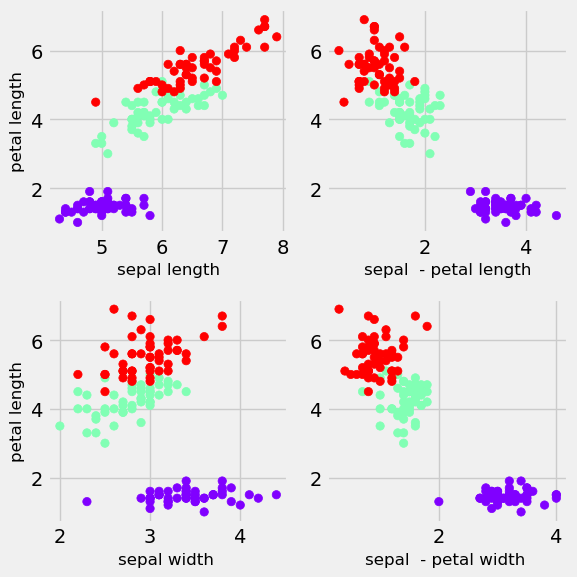

In [108]:
f, axes = plt.subplots(2,2,figsize=(6,6))
plt.style.use("fivethirtyeight")
cmap="rainbow"; fs =12
#labels = iris["target_names"][iris["target"]]
labels = iris["target_names"]
# Sepal Width 1 vs Sepal Length 0
axes[0,0].scatter(iris["data"][:,0],iris["data"][:,2],c=iris["target"],cmap=cmap,label=labels)
axes[0,0].set_xlabel(iris["feature_names"][0][:12],fontsize=fs);
axes[0,0].set_ylabel(iris["feature_names"][2][:12],fontsize=fs)
# Sepal Width 1 vs Sepal - Petal Length 0 - 2
axes[0,1].scatter(iris["data"][:,0]-iris["data"][:,2],iris["data"][:,2],c=iris["target"],cmap=cmap,label=labels)
axes[0,1].set_xlabel(iris["feature_names"][0][:6]+" - "+iris["feature_names"][2][:12],fontsize=fs) 
#axes[0,1].set_ylabel(iris["feature_names"][1][:12],fontsize=fs)
# Petal Length 2 vs Sepal Width 1
axes[1,0].scatter(iris["data"][:,1],iris["data"][:,2],c=iris["target"],cmap=cmap,label=labels)
axes[1,0].set_xlabel(iris["feature_names"][1][:12],fontsize=fs); 
axes[1,0].set_ylabel(iris["feature_names"][2][:12],fontsize=fs)
# Petal Length 2 vs Sepal - Petal Width 1 - 3
axes[1,1].scatter(iris["data"][:,1]-iris["data"][:,3],iris["data"][:,2],c=iris["target"],cmap=cmap,label=labels)
axes[1,1].set_xlabel(iris["feature_names"][1][:6]+" - "+iris["feature_names"][3][:12],fontsize=fs)
#axes[1,1].set_ylabel(iris["feature_names"][2][:12],fontsize=fs)

#plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.tight_layout()

### Discuss any structure

Purple seems to seperate out fairly cleanly in most parameter spaces.   
You can also imagine a reasonable decision boundary that could be defined between the red and green points in most cases.

### Initialize PCA with n_components=2, then train on your chosen data set. Make sure to 'whiten' it first.  
### Project the learned components on to the data set.

In [140]:
pca = PCA(n_components=2,whiten=True)
pca.fit(iris.data)
X_reduced = pca.transform(iris.data)
comp = pca.components_

### Plot the transformed data. 

In [149]:
comp[0,1]

-0.08452251406456868

Text(0, 0.5, '2nd eigenvector')

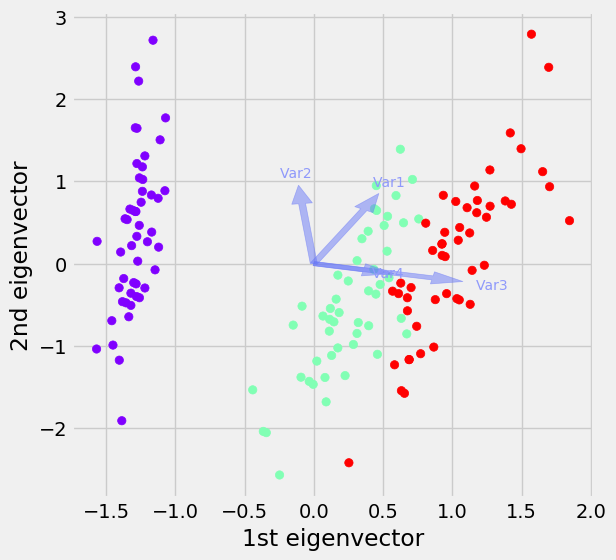

In [182]:
fig = plt.figure(1, figsize=(6, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=iris["target"],cmap=cmap)
[plt.arrow(0, 0, comp[0,i], comp[1,i],color = '#6a79f7',alpha = 0.5, width = .05) for i in np.arange(4)]
[plt.text(comp[0,i]* 1.5, comp[1,i] * 1.5, "Var"+str(i+1), color = '#8f99fb', ha = 'center', va = 'center',fontsize=10) for i in np.arange(4)]
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")

### How much of the variance in the data is captured in the first two PCA directions?

In [183]:
print("Variance")
print(pca.explained_variance_ratio_)
print("   ")
print("Components. I.E., how much each of the four features influence the principle component. \nThe higher the value in absolute value, the higher the influence on the principal component. \nThis can be seen as the variance arrows in the plot above.")
print(pca.components_)

Variance
[0.92461872 0.05306648]
   
Components. I.E., how much each of the four features influence the principle component. 
The higher the value in absolute value, the higher the influence on the principal component. 
This can be seen as the variance arrows in the plot above.
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


### First using the original data set with all of the features, then using the first two PCA directions, classify your data using any supervised classification method you like (e.g. Nearest Neighbors, Support Vector Machines, Random Forest). Make sure to first split the data into a training set and test set. Note the difference in completeness and purity. Note the difference in compute time.

Note: "It seems that outside of astronomy, the common terms for purity (TP / (TP + FP)) and completeness (TP / (TP + FN) = TPR) are "precision" and "recall".   
Source: https://github.com/drphilmarshall/SpaceWarps/issues/62  
I found that recall can also be called sensitivity or probability of detection or power.

In [244]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    confusion_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix) 

def confusionPlot(y_true,y_pred): # Mostly From Confusion Matrix Example from SciKit Learn
    cm = confusion_matrix(y_test,y_predict)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = iris["target_names"][unique_labels(y_test,y_predict)]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j],'.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

### The whole data set.

Time Elapsed 110.35669350624084 
Completeness Score 0.9502409123911644 
Purity Score 0.9866666666666667 


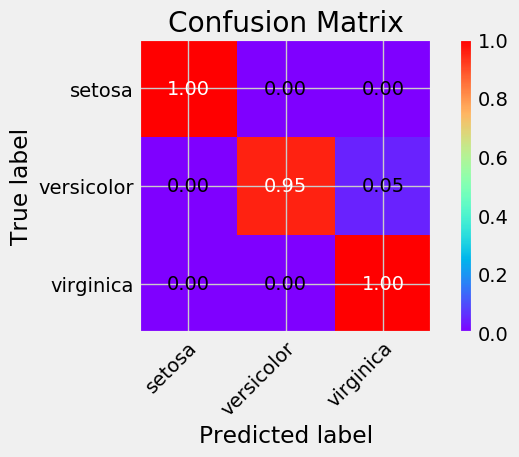

In [246]:
# Start your engines
start = time.time()

# Split up the data 
X = iris["data"]
y = iris["target"]
kf = KFold(n_splits=2,random_state =None, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Fit the Data
clf = SVC(kernel='rbf', gamma = "auto")
clf.fit(X_train,y_train)
x_min = [X[:, i].min() for i in range (4)]
x_max = [X[:, i].max() for i in range (4)]
n = 100j

# Get the Decision Boundary
d1,d2,d3,d4 = np.mgrid[x_min[0]:x_max[0]:n,x_min[1]:x_max[1]:n,x_min[2]:x_max[2]:n,x_min[3]:x_max[3]:n]
Z = clf.decision_function(np.c_[d1.ravel(), d2.ravel(), d3.ravel(), d4.ravel()])

# Get the predictions 
y_predict = clf.predict(X_test)

# Evalue with metrics
complete = completeness_score(y_test,y_predict)
pure = purity_score(y_test,y_predict)
print(("Time Elapsed {} ").format(time.time()-start))
print(("Completeness Score {} ").format(complete))
print(("Purity Score {} ").format(pure))

# Plot of Confusion Matrix
confusionPlot(y_test,y_predict)

#### The first two PCA Directions

Time Elapsed 0.012894153594970703 
Completeness Score 0.8828835465400372 
Purity Score 0.96 


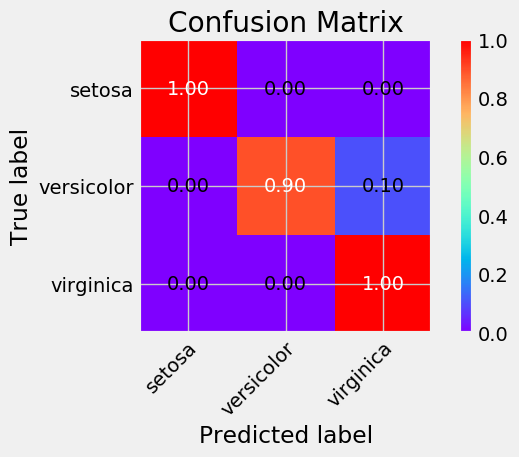

In [245]:
# Start your engines
start = time.time()

# Split up the data 
X = X_reduced
y = iris["target"]
kf = KFold(n_splits=2,random_state =None, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Fit the Data
clf = SVC(kernel='rbf', gamma = "auto")
clf.fit(X_train,y_train)
x_min = [X[:, i].min() for i in range (2)]
x_max = [X[:, i].max() for i in range (2)]
n = 100j

# Get the Decision Boundary
d1,d2 = np.mgrid[x_min[0]:x_max[0]:n,x_min[1]:x_max[1]:n]
Z = clf.decision_function(np.c_[d1.ravel(), d2.ravel()])

# Get the predictions 
y_predict = clf.predict(X_test)

# Evalue with metrics
complete = completeness_score(y_test,y_predict)
pure = purity_score(y_test,y_predict)
print(("Time Elapsed {} ").format(time.time()-start))
print(("Completeness Score {} ").format(complete))
print(("Purity Score {} ").format(pure))

# Plot of Confusion Matrix
confusionPlot(y_test,y_predict)

### Was dimensionality reduction a useful algorithm in the case of the data set you picked?  
- Yes. It was 450 times faster and almost as accurate with an additional false positive rate of .05.

### What characteristics of the data set would you look for before deciding to do dimensionality reduction?  
- Data that had more than 3 or 4 dimensions or was so large that computing more than 2 dimensions was extremely time intensive.